CrossEntropy with Softmax cause derivate is simple
One-hot coding: (1 0 0) for class 1

1. Adam - SGD
2. Regularization - Ridge Lasso, Early stop (at epochs when validation accuracy increase = highest genelization or when lowest validation error), Drop out, Batch Normalization
3. Imbalance Data Set: Oversampling, in the loss function (CrossEntropy) change weight
4. Architecture NN : combination(Deep - Cascading with XGBoost), padding, TensorFlow
5. Data augmentation: random transformation but not augmentation, ex: flip, zoom...
6. Validation for overfitting and hyperparameter
7. Visualization 
8. FCN, Global Avege Pooling, SW NMS isn't used today
9. SSD, alternative of SW : Region Proposals
10. Selective Search, combine all => Faster R-CNN, RPN => Mask R-CNN, MNC
11. Yolo similer to SSD, SegNet : ecode - decode

In [89]:
# Load image
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import cv2

#os.chdir('./train_images/..')
train_dir = './train_images'  # folder containing training images
test_dir = './test_images'    # folder containing test images

transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
     transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
     transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

transform_new = transforms.Compose(
    [transforms.Grayscale(),
     transforms.RandomResizedCrop(36, scale=(0.8, 1.0), ratio=(1, 1)),
     transforms.RandomHorizontalFlip(p=1),
     # transforms.RandomVerticalFlip(p=0.1),
     # transforms.RandomRotation((-10, +10)),
     transforms.ToTensor(),    
     transforms.Normalize(mean=(0.5,),std=(0.5,))])

# Define two pytorch datasets (train/test) 
train_data_old = ImageFolder(train_dir, transform=transform)
train_data_new = ImageFolder(train_dir, transform=transform_new)
test_data = ImageFolder(test_dir, transform=transform)
#train_data = ConcatDataset([train_data_old, train_data_new])

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32    

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data_new)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# Define a "sampler" that will construct automatically a more ballanced training set
imbalance_sampler = ImbalancedDatasetSampler(train_data_new)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = DataLoader(train_data_new, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valid_loader = DataLoader(train_data_new, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
train_loader_ib = DataLoader(train_data_new, batch_size=batch_size, sampler=imbalance_sampler, num_workers=2)

classes = ('noface','face')  # indicates that "1" means "face" and "0" non-face (only used for display)

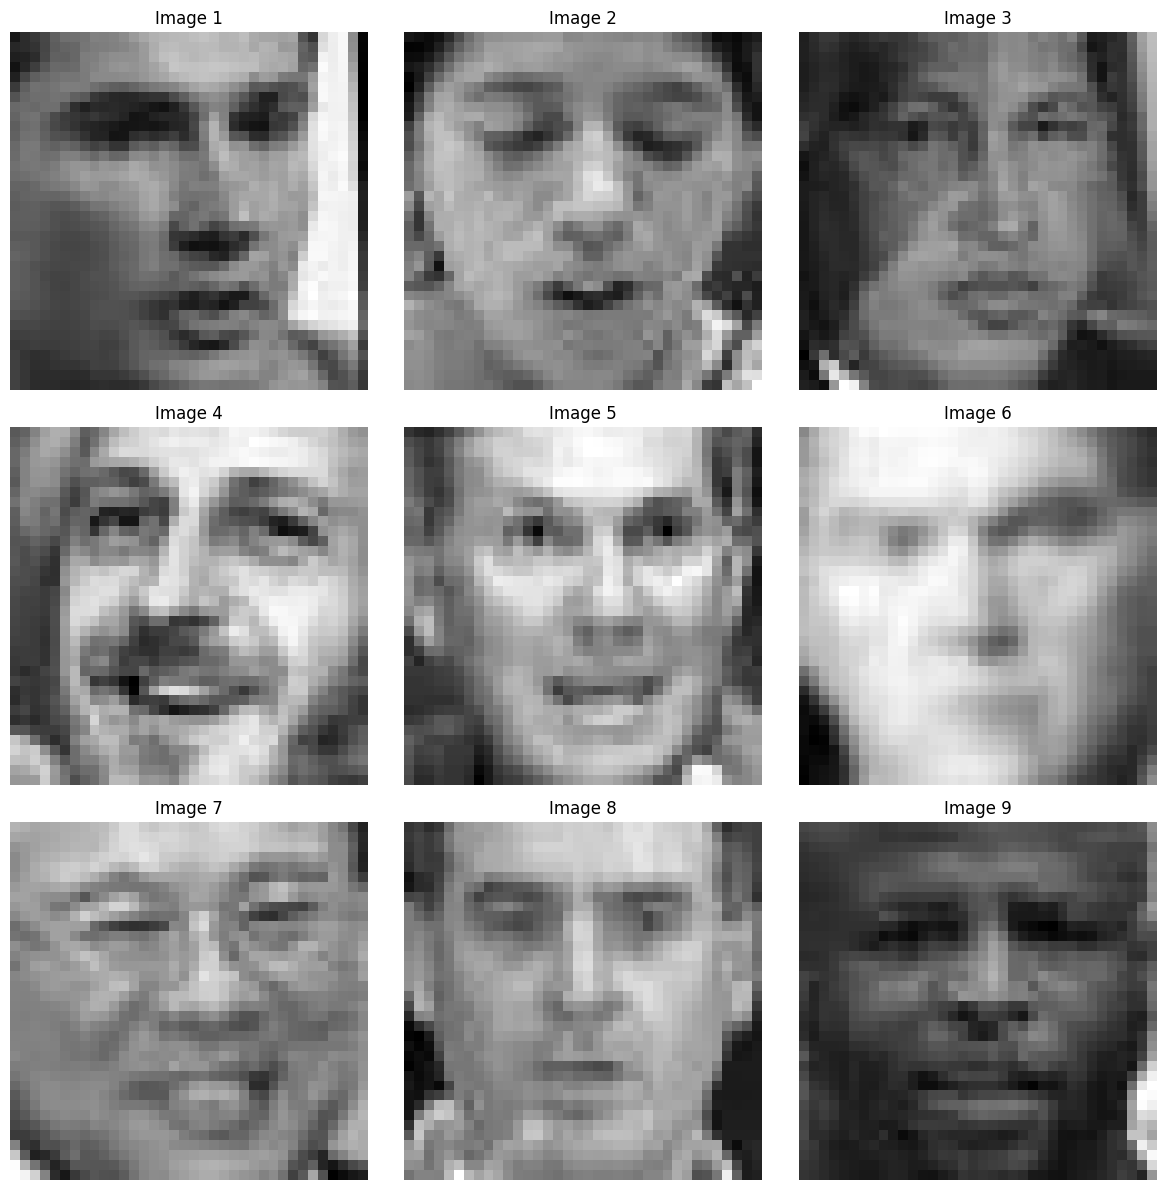

In [90]:
# Visualize original dataset

image_paths = []
# Load PGM image
for i in range(0, 45, 5):
    index = 1000 + i
    path = (f"./train_images/1/Image00{index}.pgm")
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image_paths.append(path)
    else:
        print("Error: Failed to load the image.")
        
# Display training image examples
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    if i < len(image_paths):
        image = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Turn off axis labels
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

./train_images/1/1_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/11_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/21_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/31_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/41_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/51_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/61_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/71_0__t0,0_r0_s1.pgm
Error: Failed to load the image.
./train_images/1/81_0__t0,0_r0_s1.pgm
Error: Failed to load the image.


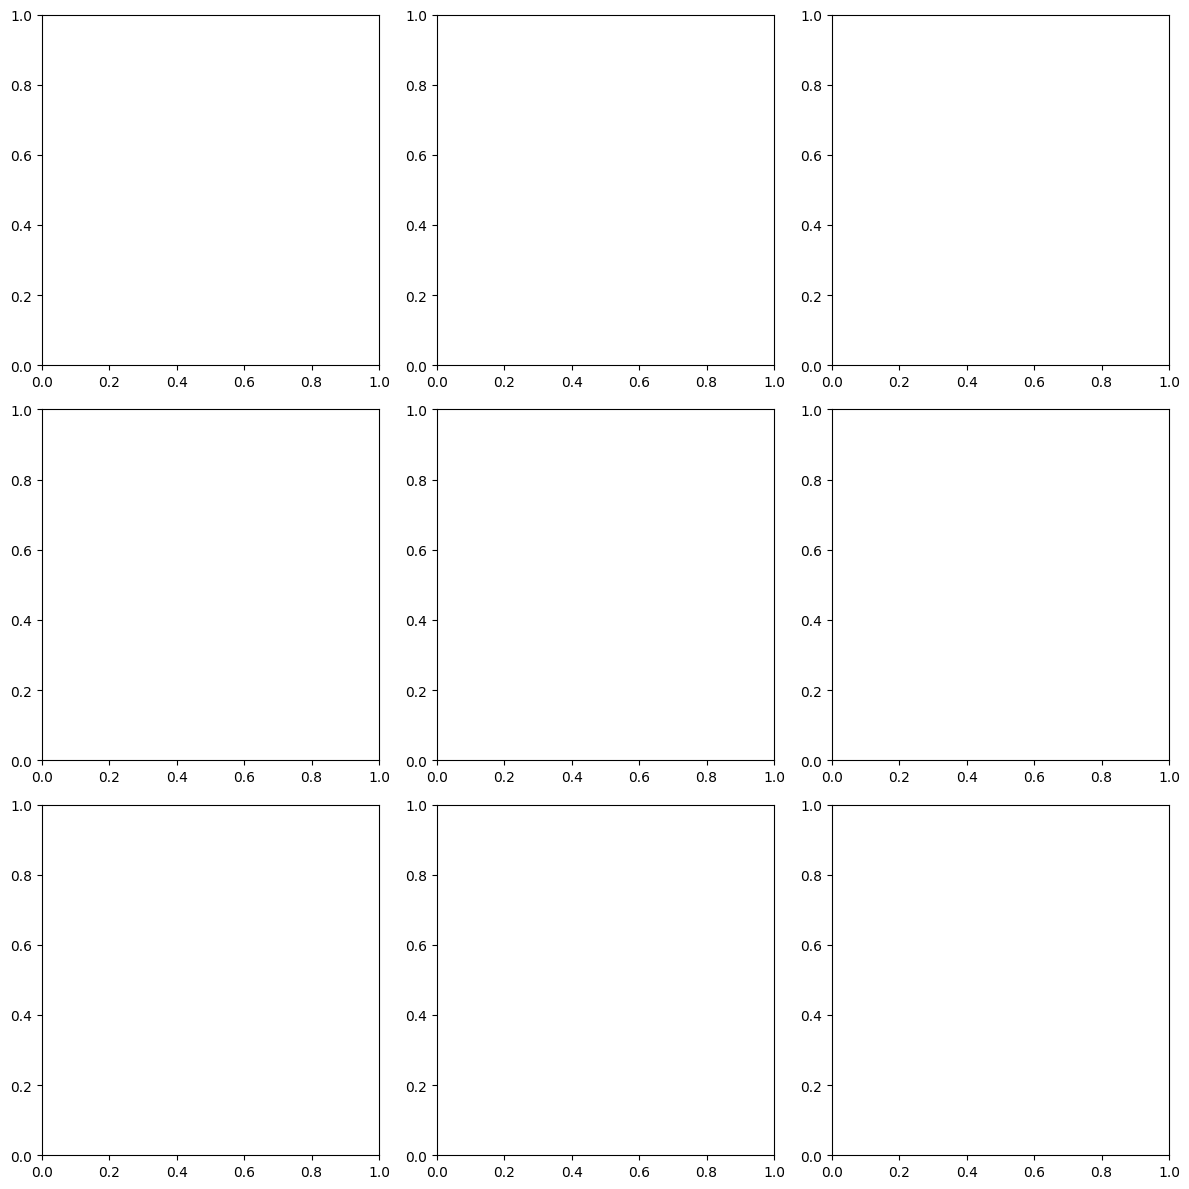

In [91]:
# Visualize test dataset

image_paths_test = []
# Load PGM image
for i in range(1, 90, 10):
    path = (f"./train_images/1/{i}_0__t0,0_r0_s1.pgm")
    print(path)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image_paths_test.append(path)
    else:
        print("Error: Failed to load the image.")
        
# Display training image examples
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    if i < len(image_paths_test):
        image = cv2.imread(image_paths_test[i], cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Turn off axis labels
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

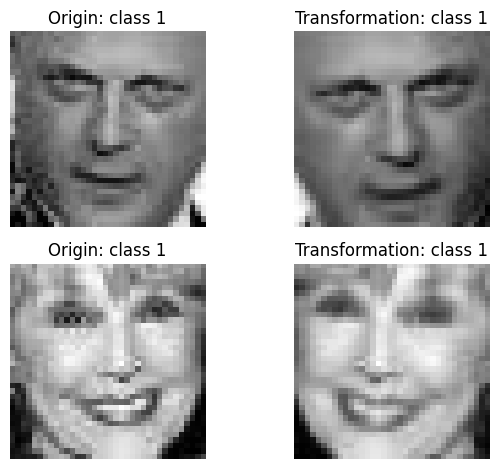

In [48]:
# Visualize transformed image for data augmentation
image_tr_1, label_tr_1 = train_data_new[66666]
image_or_1, label_or_1 = train_data_old[66666]

image_tr_2, label_tr_2 = train_data_new[77777]
image_or_2, label_or_2 = train_data_old[77777]
# Convert the image tensor to a NumPy array for visualization
image_tr_1 = image_tr_1.permute(1, 2, 0).numpy()
image_or_1 = image_or_1.permute(1, 2, 0).numpy()

image_tr_2 = image_tr_2.permute(1, 2, 0).numpy()
image_or_2 = image_or_2.permute(1, 2, 0).numpy()
# Visualize the image using Matplotlib
plt.subplot(2, 2, 1)
plt.imshow(image_or_1, cmap = 'gray')
plt.title(f'Origin: class {label_or_1}')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image_tr_1, cmap = 'gray')
plt.title(f'Transformation: class {label_tr_1}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image_or_2, cmap = 'gray')
plt.title(f'Origin: class {label_or_2}')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_tr_2, cmap = 'gray')
plt.title(f'Transformation: class {label_tr_2}')
plt.axis('off')

plt.tight_layout()
plt.show()

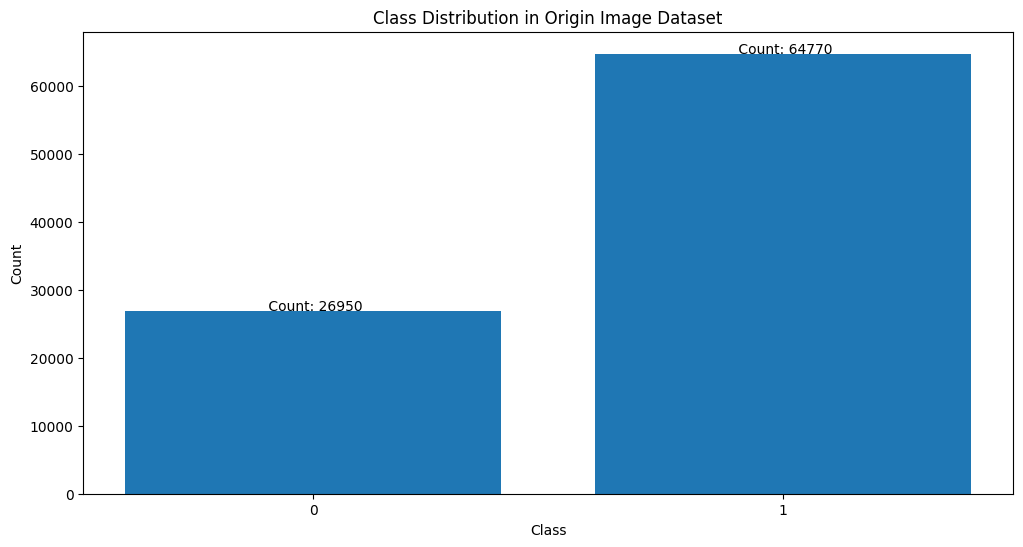

In [49]:
# Display Distribution

# Classification
class_distribution = {}
for _, label in train_data_old:
    class_name = train_data_old.classes[label]
    if class_name in class_distribution:
        class_distribution[class_name] += 1
    else:
        class_distribution[class_name] = 1
        
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Origin Image Dataset')
# Add custom legend
for class_label, count in class_distribution.items():
    plt.text(class_label, count, f' Count: {count}', ha='center')
plt.show()

In [50]:
# Construct CNN model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [70]:
# Improve CNN model with Drop Out

class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.conv3 = nn.Conv2d(16, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.pool(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [52]:
# Train 
n_epochs = 10 # 25
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

In [60]:
# SGD
net_sgd = Net()
optimizer = optim.SGD(net_sgd.parameters(), lr=learning_rate, momentum=0.9)
running_loss_SGD  = []
# loop over epochs: one epoch = one pass through the whole training dataset
for epoch in range(1, n_epochs+1):  
#   loop over iterations: one iteration = 1 batch of examples
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net_sgd(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data))
    running_loss_SGD.append(loss.data)

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.676280
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.057984
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.134948
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.012505
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.006904
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.007388
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.014552
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.038308
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.006050
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.001572


In [61]:
# Adam
net_adam = Net()
optimizer = optim.Adam(net_adam.parameters(), lr=learning_rate)
running_loss_Adam  = []
for epoch in range(1, n_epochs+1):  
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net_adam(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data))
    running_loss_Adam.append(loss.data)

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.574373
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.053609
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.000665
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.017528
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.001574
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.001048
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.000239
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.000052
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.000004
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.000853


execution time but mini-batch, problem of overfitting in test set

In [69]:
# Implement basic "Early Stop" strategy
net_ES = Net()
optimizer = optim.Adam(net_adam.parameters(), lr=learning_rate)

best_metric = float('inf')  # Initialize with a large value for loss
patience = 5  # Number of epochs to wait for metric improvement
wait = 0  # Counter for how many epochs the metric hasn't improved
early_stopped = False  # Flag to check if early stopping occurred

for epoch in range(1, n_epochs+1):
    
    # TRAINING LOOP
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net_ES(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),loss.data))
            

    
    # VALIDATION LOOP
    
    # Set to evaluation mode
    net_ES.eval()
    with torch.no_grad():
        # Calculate the metric on validation set
        for batch_idx_valid, (data_valid, target_valid) in enumerate(valid_loader): 
            net_out_valid = net_ES(data_valid)
            current_metric = criterion(net_out_valid, target_valid)
        # Check if the metric has improved
        if current_metric < best_metric:
            best_metric = current_metric
            wait = 0
            # Save the model's state
            torch.save(net_ES.state_dict(), 'best_model.pth')
        else:
            wait += 1
        if wait >= patience:
            print(f"Early stopping after {epoch} epochs.")
            early_stopped = True
            break
# Load the best model (if early stopping didn't occur)
if not early_stopped:
    net_ES.load_state_dict(torch.load('./best_model.pth'))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.727250
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.714046
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.729821
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.723751
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.731941
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.713751
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.695486
Train Epoch: 8 [0/91720 (0%)]	Loss: 0.722247
Train Epoch: 9 [0/91720 (0%)]	Loss: 0.723502
Train Epoch: 10 [0/91720 (0%)]	Loss: 0.727046


In [71]:
# Architecture Deep Leaning
net_new = Net_new()
optimizer = optim.Adam(net_new.parameters(), lr=learning_rate, weight_decay = 0.01)
for epoch in range(1, n_epochs+1):  
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net_new(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2860 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),loss.data))

Train Epoch: 1 [0/91720 (0%)]	Loss: 0.804798
Train Epoch: 1 [32000/91720 (44%)]	Loss: 0.105792
Train Epoch: 1 [64000/91720 (87%)]	Loss: 0.068538
Train Epoch: 2 [0/91720 (0%)]	Loss: 0.217747
Train Epoch: 2 [32000/91720 (44%)]	Loss: 0.040779
Train Epoch: 2 [64000/91720 (87%)]	Loss: 0.047438
Train Epoch: 3 [0/91720 (0%)]	Loss: 0.139676
Train Epoch: 3 [32000/91720 (44%)]	Loss: 0.078475
Train Epoch: 3 [64000/91720 (87%)]	Loss: 0.051753
Train Epoch: 4 [0/91720 (0%)]	Loss: 0.037926
Train Epoch: 4 [32000/91720 (44%)]	Loss: 0.027858
Train Epoch: 4 [64000/91720 (87%)]	Loss: 0.036780
Train Epoch: 5 [0/91720 (0%)]	Loss: 0.037992
Train Epoch: 5 [32000/91720 (44%)]	Loss: 0.024498
Train Epoch: 5 [64000/91720 (87%)]	Loss: 0.029352
Train Epoch: 6 [0/91720 (0%)]	Loss: 0.059456
Train Epoch: 6 [32000/91720 (44%)]	Loss: 0.011731
Train Epoch: 6 [64000/91720 (87%)]	Loss: 0.035736
Train Epoch: 7 [0/91720 (0%)]	Loss: 0.047008
Train Epoch: 7 [32000/91720 (44%)]	Loss: 0.074811
Train Epoch: 7 [64000/91720 (87%)]	

In [ ]:
# Regularization Lasso L1
net_L1 = Net_new()
lambda_L1 = 0.001
optimizer = optim.Adam(net_L1.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs+1):  
    for data, target in train_loader:
        optimizer.zero_grad()
        net_out_adam_reg_L1 = net_L1(data)
        norm_L1 = sum(torch.linalg.norm(p.view(-1, 1), 1) for p in net_new.parameters())
        loss = criterion(net_out_adam_reg_L1, target) + lambda_L1 * norm_L1
        loss.backward()
        optimizer.step()

In [ ]:
# Select hyperparameter using Cross-Validation 
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5)

# Perform cross-validation
scores = cross_val_score(pytorch_model, X, y, cv=cv, scoring='accuracy')
X = []
y = []

for batch in dataloader:
    inputs, labels = batch
    
    # Assuming `inputs` is a tensor representing your input data
    # and `labels` is a tensor representing your labels/targets
    
    X.append(inputs)
    y.append(labels)

# Concatenate the lists to create tensors
X = torch.cat(X, dim=0)
y = torch.cat(y, dim=0)

L2 is more stable and use validation set to choose the best hyperparameter lambda

In [72]:
# Test
correct_sgd_train = 0
correct_adam_train = 0
correct_new_train = 0
total_train = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        total_train += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_train += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_train += (predicted_adam == labels).sum().item()
        # new 
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_train += (predicted_new == labels).sum().item()
   
correct_sgd_valid = 0
correct_adam_valid = 0
correct_new_valid = 0
total_valid = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        total_valid += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_valid += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_valid += (predicted_adam == labels).sum().item()
        # Deep 
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_valid += (predicted_new == labels).sum().item()
     
correct_sgd_test = 0
correct_adam_test = 0
correct_new_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        total_test += labels.size(0)
        # SGD
        outputs_sgd = net_sgd(images)
        _, predicted_sgd = torch.max(outputs_sgd.data, 1)
        correct_sgd_test += (predicted_sgd == labels).sum().item()
        # Adam
        outputs_adam = net_adam(images)
        _, predicted_adam = torch.max(outputs_adam.data, 1)
        correct_adam_test += (predicted_adam == labels).sum().item()
        # Deep
        outputs_new = net_new(images)
        _, predicted_new = torch.max(outputs_new.data, 1)
        correct_new_test += (predicted_new == labels).sum().item()
        
print('Accuracy of the network(SGD) on the 73376 train images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_train / total_train), correct_sgd_train, total_train))
print('Accuracy of the network(SGD) on the 18344 validation images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_valid / total_valid), correct_sgd_valid, total_valid))
print('')
print('Training Set')
print('Accuracy of the network(SGD) on the 73376 train images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_train / total_train), correct_sgd_train, total_train))
print('Accuracy of the network(Adam) on the 73376 train images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_train / total_train), correct_adam_train, total_train))
print('Accuracy of the network(new architecture) on the 73376 train images: {:.4f} %  with  {} / {}'.format((100 * correct_new_train / total_train), correct_new_train, total_train))
print('')
print('Validation Set')
print('Accuracy of the network(SGD) on the 18344 validation images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_valid / total_valid), correct_sgd_valid, total_valid))
print('Accuracy of the network(Adam) on the 18344 validation images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_valid / total_valid), correct_adam_valid, total_valid))
print('Accuracy of the network(new architecture) on the 18344 validation images: {:.4f} %  with  {} / {}'.format((100 * correct_new_valid / total_valid), correct_new_valid, total_valid))
print('')
print('Test Set')
print('Accuracy of the network(SGD) on the 7628 test images: {:.4f} %  with {} / {}'.format((100 * correct_sgd_test / total_test), correct_sgd_test, total_test))
print('Accuracy of the network(Adam) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_adam_test / total_test), correct_adam_test, total_test))
print('Accuracy of the network(new architecture) on the 7628 test images: {:.4f} %  with  {} / {}'.format((100 * correct_new_test / total_test), correct_new_test, total_test))

Accuracy of the network(SGD) on the 73376 train images: 99.7097 %  with 73163 / 73376
Accuracy of the network(SGD) on the 7628 test images: 99.4767 %  with 18248 / 18344

Training Set
Accuracy of the network(SGD) on the 73376 train images: 99.7097 %  with 73163 / 73376
Accuracy of the network(Adam) on the 73376 train images: 99.6538 %  with  73122 / 73376
Accuracy of the network(new architecture) on the 73376 train images: 98.8007 %  with  72496 / 73376

Validation Set
Accuracy of the network(SGD) on the 7628 test images: 99.4767 %  with 18248 / 18344
Accuracy of the network(Adam) on the 7628 test images: 99.4331 %  with  18240 / 18344
Accuracy of the network(new architecture) on the 7628 test images: 98.7135 %  with  18108 / 18344

Test Set
Accuracy of the network(SGD) on the 7628 test images: 93.7205 %  with 7149 / 7628
Accuracy of the network(Adam) on the 7628 test images: 94.1007 %  with  7178 / 7628
Accuracy of the network(new architecture) on the 7628 test images: 92.3964 %  with

In [ ]:
# Visualize training process
# # TensorFlow

# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# model = Sequential()

# model.add(Conv2D(6, (3, 3), activation='relu', input_shape=(36, 36, 1)))
# model.add(BatchNormalization())
# #model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(8, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(12, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(12 * 7 * 7, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.summary()

# history = model.fit_generator(
#     train_generator, 
#     epochs=n_epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )
